# Libraries and Packages Import

In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
import os, itertools, csv
import progressbar
import matplotlib.pyplot as plt

# text related
import re
from bs4 import BeautifulSoup
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# sklearn
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.impute import SimpleImputer

# User Defined Functions and Classes

In [10]:
def preprocessor(text):
    """
    - remove HTML tags
    - remove punctuation
    - convert to lowercase
    """
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [9]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    """
    - tokenization
    - word-stemming
    - remove stop-word
    """
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk
from nltk import word_tokenize

def count_words(text):
    return len(text.split())

def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [15]:
def data_preprocess(text):
    bs = BeautifulSoup(text, 'html.parser')
    
    title = bs.find(class_="title").text
    content = bs.find(class_="article-content").text
    channel = bs.find("article")["data-channel"]
    # tag = bs.find(class_="article-topics").text
    # match = re.compile('Topics:')
    # tag = match.sub(r' ', tag)
    topic_tags = bs.find('footer', class_="article-topics").find_all('a')
    topics = [t.get_text() for t in topic_tags]
    tag = ' '.join(topics)
    fig_count = len(bs.find_all('img'))
    link_count = len(bs.find_all('a'))

    # modify area
    word_count = len(text.split())
    # capital_word_count = sum(map(str.isupper,text.split()))
    # sentence_count = len(nltk.sent_tokenize(text))
    # unique_word_count = len(set(text.split()))
    # htags_count = re.findall(r'(#w[A-Za-z0-9]*)', text)
    # words_in_quotes_count = count_words_in_quotes(text)
    # stopwords_count = count_stopwords(text)
    
    time = bs.find('time')
    timestamp, weekday, month = np.NaN, np.NaN, np.NaN
    if time.has_attr('datetime'):
        time = datetime.strptime(time['datetime'], '%a, %d %b %Y %H:%M:%S %z')
        weekday = 0 if time.weekday() > 4 else 1
        month = 1 if time.month > 5 else 0
        timestamp = time.timestamp()

    return {
            "title": title, 
            "content": content,
            "tag":  tag,
            "channel": channel, 
            "fig_count":  fig_count,
            "link_count":  link_count,
            "weekday":  weekday,
            "month": month,
            "timestamp":  timestamp,
            "word_count": word_count
            }

# data_preprocess(df.loc[0,'Page content'])

In [14]:
# Custom transformer for sklearn pipeline
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols_from, cols_to):
        self.cols_from = cols_from
        self.cols_to = cols_to

    def transform(self, X):
        col_data = pd.DataFrame()
        col_data = X.iloc[:, self.cols_from:self.cols_to]
        return col_data.values

    def fit(self, X, y=None):
        return self

# Data Pre-processing

In [3]:
df = pd.read_csv('../data/train.csv')
df.head()

,Id,Popularity,Page content
0,0,-1,"<html><head><div class=""article-info""> <span c..."
1,1,1,"<html><head><div class=""article-info""><span cl..."
2,2,1,"<html><head><div class=""article-info""><span cl..."
3,3,-1,"<html><head><div class=""article-info""><span cl..."
4,4,-1,"<html><head><div class=""article-info""><span cl..."


In [12]:
nltk.download('punkt')
nltk.download('stopwords')

train_data = pd.DataFrame(columns=["title", "content", "tag", "channel", "fig_count", "link_count", "weekday", "month", "timestamp", "word_count"])
train_label = pd.DataFrame(columns=["Popularity"])
pgbar = progressbar.ProgressBar(widgets=['Progress: ',progressbar.Percentage(), ' ', progressbar.Bar('#'), progressbar.ETA()])
for i in pgbar(range(len(df))):
    train_data = train_data.append(data_preprocess(df.loc[i,'Page content']), ignore_index=True)
    train_label = train_label.append({"Popularity": df.loc[i, "Popularity"]}, ignore_index=True)
    
train_data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Che\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count
0,NASA's Grand Challenge: Stop Asteroids From De...,There may be killer asteroids headed for Eart...,Asteroid Asteroids challenge Earth Space U.S. ...,world,1,22,1,1,1.371654e+09,658
1,Google's New Open Source Patent Pledge: We Won...,Google took a stand of sorts against patent-l...,Apps and Software Google open source opn pledg...,tech,2,18,1,0,1.364492e+09,390
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,You've spend countless hours training to be a...,Entertainment NFL NFL Draft Sports Television,entertainment,2,11,1,0,1.399490e+09,1884
3,Cameraperson Fails Deliver Slapstick Laughs,Tired of the same old sports fails and ne...,Sports Video Videos Watercooler,watercooler,1,13,1,1,1.381458e+09,858
4,NFL Star Helps Young Fan Prove Friendship With...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",Entertainment instagram instagram video NFL Sp...,entertainment,52,16,1,0,1.397706e+09,2831


In [22]:
label_le = LabelEncoder()
train_data["channel"] = label_le.fit_transform(train_data["channel"].values)
train_data["word_count"] = label_le.fit_transform(train_data["word_count"].values)

old_data = train_data
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=['title','content', 'tag']), train_label['Popularity'].astype('int'),
                                                    test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

(22114, 7) (22114,)
(5529, 7) (5529,)


,channel,fig_count,link_count,weekday,month,timestamp,word_count
3492,3,2,15,1,1,1.383328e+09,265
9375,3,2,8,1,1,1.409834e+09,364
17129,20,1,14,1,1,1.387937e+09,261
27200,31,1,15,1,1,1.413211e+09,127
22507,28,21,39,0,0,1.358004e+09,1976


# Models

## Train Model

In [36]:
# param
param_est = [50, 200, 500, 800]
param_depth = [5, 15, 25]
param_grid = [{'clf__n_estimators': param_est, 
               'clf__max_depth': param_depth}]

pipe = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_jobs=-1, random_state=1))
                ])

gs = GridSearchCV(
    estimator = pipe, 
    param_grid = param_grid, 
    scoring = 'roc_auc',
    cv = 10
)

gs = gs.fit(X_train, y_train)
print('[SVC: grid search]')
print('Validation roc_auc score: %.3f' % gs.best_score_)
print(gs.best_params_)

best_clf = gs.best_estimator_

[SVC: grid search]
Validation roc_auc score: 0.585
{'clf__max_depth': 5, 'clf__n_estimators': 500}


## Test the Best Model

Validation Accuracy: 0.5549
AUC: 0.5774


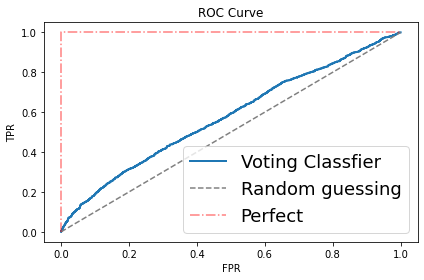

In [37]:
# Best Model

proba = best_clf.predict_proba(X_test)
y_pred = best_clf.predict(X_test)
print('Validation Accuracy: %.4f' % accuracy_score(y_test, y_pred))
# Use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 proba[:, 1],
                                pos_label=1)
print('AUC: %.4f' % auc(fpr, tpr))


plt.plot(fpr, tpr, lw=2,
         label='Voting Classfier')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
plt.show()

# Testing and Output

In [38]:
df_real = pd.read_csv('../data/test.csv')

test_data = pd.DataFrame(columns=["title", "content", "tag", "channel", "fig_count", "link_count", "weekday", "month", "timestamp", "word_count"])
pgbar = progressbar.ProgressBar(widgets=['Progress: ',progressbar.Percentage(), ' ', progressbar.Bar('#'), progressbar.ETA()])
for i in pgbar(range(len(df_real))):
    test_data = test_data.append(data_preprocess(df_real.loc[i,'Page content']), ignore_index=True)
    
label_le = LabelEncoder()
test_data["channel"] = label_le.fit_transform(test_data["channel"].values)
test_data["word_count"] = label_le.fit_transform(test_data["word_count"].values)
test_data = test_data.drop(columns=['title', 'content', 'tag'])
test_data.head()


,channel,fig_count,link_count,weekday,month,timestamp,word_count
0,5,1,30,1,1,1.378756e+09,734
1,25,3,13,1,1,1.383212e+09,109
2,2,2,13,1,1,1.372165e+09,122
3,6,1,15,1,0,1.360726e+09,216
4,5,1,10,1,1,1.412300e+09,183


In [39]:
best_clf.fit(train_data.drop(columns=['title', 'content', 'tag']), train_label['Popularity'].astype('int'))
result = best_clf.predict_proba(test_data)
out = pd.DataFrame({'Id': df_real.Id, 'Popularity': result[:, 1]})
out.to_csv('./output/predict.csv', index=False)
print(out)

          Id  Popularity
0      27643    0.448810
1      27644    0.451918
2      27645    0.430612
3      27646    0.479203
4      27647    0.444981
...      ...         ...
11842  39485    0.731861
11843  39486    0.556105
11844  39487    0.536741
11845  39488    0.438744
11846  39489    0.471026

[11847 rows x 2 columns]


AUC score on Kaggle public testing dataset: <b>0.57219</b>